In [57]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
#from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [58]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [98]:
train = """

select play.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
       box_view.home_away,
       basic.minutes_played,
       basic.fg,
       basic.fga,
      -- basic.fg_pct,
       basic.3p,
       basic.3pa,
      -- basic.3p_pct,
       basic.ft,
      -- basic.ft_pct,
       basic.orb,
      -- basic.drb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
      -- basic.tov,
       basic.pf,
      -- adv.true_shooting_pct,
       adv.effective_fg_pct,
       adv.3P_attempt_rate,
       adv.FT_attempt_rate,
       adv.offensive_reb_rate,
      -- adv.defensive_reb_rate,
       adv.total_reb_pct,
       adv.assist_pct,
       adv.steal_pct,
       adv.block_pct,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
      -- adv.offensive_rating,
      -- adv.defensive_rating,
       basic.pts
from (

    select m.game_hash, m.team, m.game_date, m.home_away, lu.season
    from box_scores_map_view as m
    inner join game_date_lookup as lu on m.game_date = lu.day
    where m.game_date < current_date and
          lu.season > 2010
    order by game_date desc

         ) as box_view
inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
        box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
        play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
        play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
inner join player_info as play on play_m.player_id = play.player_id
order by box_view.game_date desc;


"""

In [99]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [75]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [76]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [77]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [100]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [101]:
clean_df = concat_drop(df[df['minutes_played'] >= 600], ['home_away'], ['player_id', 'team', 'game_hash', 'game_date', 'home_away', 'fg', '3p', 'ft'])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':'pace'], clean_df.loc[:, 'pts'], test_size=.33)

In [103]:
lm = LinearRegression()

In [104]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

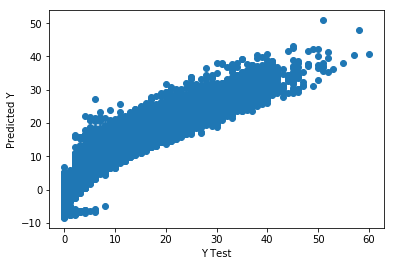

In [106]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

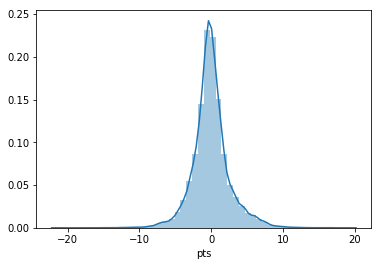

In [107]:
sns.distplot((y_test-predictions),bins=50);

In [108]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.001762
fga,0.949360
3pa,0.117643
orb,-0.237799
trb,0.059818
ast,-0.140570
stl,0.171946
blk,0.093284
pf,-0.023740
effective_fg_pct,10.913256


In [109]:
lm.score(X_test, y_test)

0.88525425457017959